https://dongjk.github.io/code/object+detection/keras/2018/05/21/Faster_R-CNN_step_by_step,_Part_I.html
https://www.kaggle.com/kishor1210/train-faster-rcnn-using-keras
https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
https://www.programmersought.com/article/47744573673/
https://proceedings.neurips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf
https://openaccess.thecvf.com/content_iccv_2015/papers/Girshick_Fast_R-CNN_ICCV_2015_paper.pdf

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Dense
import tensorflow as tf
from datetime import datetime
%load_ext tensorboard
%tensorboard --logdir logs/scalars

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 16200.

In [2]:
import os
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K


# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [4]:
!pip3 install pyqt5 lxml

# XML parser

In [3]:
!pip install xmltodict

In [3]:
FOLDER_PATH = "anotations"

from utils import read_data, plot_image

In [4]:
import utils
import numpy as np

In [5]:
bbox, images = read_data(FOLDER_PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


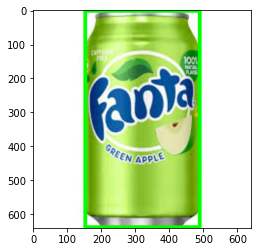

In [6]:
# not work because in reading step bounding boxes are already multiplied 
plot_image(images[0], bbox[0])

# Network training 

# backbone 

Vgg 16 

In [15]:
vvg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [16]:
res = vvg16.predict(images)

## helper functions 

all helper functions moved to utils

## loss function 

loss function moved to utils

there should be a mistake how ious (problem was with dimensions of pois and thta no IOU was bigger than threshold) and deltas are calculated 

## Model

because of compicated loss function, model training can be implemented in few ways:

    * create a loss layer, train the model and move trained weights to model without loss layer 
    * create a custom model with its own custom train_step 

### option 1:

In [17]:


import utils 

class LossLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(LossLayer, self).__init__()
        self.bbox = tf.constant(utils.generate_bbox_coords(dims = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])), dtype = tf.float32)
        self.loss_fn = utils.my_loss_fn
        self.loss_res = tf.constant([0])

    def call(self, output_scores, output_deltas, bounding_box, training=None):
        if training:
            self.loss_res , class_loss, regression_loss_l1  = self.loss_fn(
                                                                        tf.cast(bounding_box, dtype = tf.float32),
                                                                        output_scores,
                                                                        tf.cast(output_deltas, dtype = tf.float32),
                                                                        self.bbox,
                                                                        tf.constant(10, dtype = tf.float32),
                                                                        range_positive=0.5)
            self.add_loss(self.loss_res)
            self.add_metric(class_loss, name = "class_loss")
            self.add_metric(regression_loss_l1, name = "regression_loss_l1")
        return self.loss_res

In [18]:
layer = LossLayer()

In [19]:
layer.bbox.shape

TensorShape([8400, 4])

In [20]:
feature_map_tile = Input(shape=(20,20,512))
k = 21 # because of 9 different shapes

gt_bbox = Input(shape=(None, 4))
convolution_3x3 = Conv2D(
    filters=512,
    padding = "same",
    kernel_size=(3, 3),
    name="3x3"
)(feature_map_tile)

output_deltas = Conv2D(
    filters= 4 * k,
    kernel_size=(1, 1),
    activation="linear",
    kernel_initializer="uniform",
    name="deltas1"
)(convolution_3x3)

output_scores = Conv2D(
    filters=k,
    kernel_size=(1, 1),
    activation="sigmoid",
    kernel_initializer="uniform",
    name="scores1"
)(convolution_3x3)


loss_layer = LossLayer()(output_scores, output_deltas, gt_bbox)

model = Model(inputs=[feature_map_tile, gt_bbox], outputs=[loss_layer])

In [21]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 20, 512) 0                                            
__________________________________________________________________________________________________
3x3 (Conv2D)                    (None, 20, 20, 512)  2359808     input_4[0][0]                    
__________________________________________________________________________________________________
scores1 (Conv2D)                (None, 20, 20, 21)   10773       3x3[0][0]                        
__________________________________________________________________________________________________
deltas1 (Conv2D)                (None, 20, 20, 84)   43092       3x3[0][0]                        
_______________________________________________________________________________________

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam()
)

In [23]:
res_one = tf.expand_dims(res[1], axis = 0)

In [24]:
bbox_one = tf.expand_dims(bbox[1], axis = 0)

create dummy targets as they wont be used in training. real targets are gives as inputs to model 

In [25]:
import numpy as np
dummy_target = np.tile(np.array([[1]]), (res_one.shape[0], 1))

In [26]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit([res_one, bbox_one], dummy_target, batch_size=1, epochs = 5000, callbacks=[tensorboard_callback])

Epoch 1/5000
1/1 [==============================] - 0s 6ms/step - loss: 17.8876 - class_loss: 2.9304 - regression_loss_l1: 1.4957
Epoch 2/5000
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 6ms/step - loss: 118.6483 - class_loss: 1.4670 - regression_loss_l1: 11.7181
Epoch 3/5000
1/1 [==============================] - 0s 9ms/step - loss: 87.5500 - class_loss: 0.6116 - regression_loss_l1: 8.6938
Epoch 4/5000
1/1 [==============================] - 0s 9ms/step - loss: 71.5773 - class_loss: 0.4400 - regression_loss_l1: 7.1137
Epoch 5/5000
1/1 [==============================] - 0s 10ms/step - loss: 19.8269 - class_loss: 0.4338 - regression_loss_l1: 1.9393
Epoch 6/5000
1/1 [==============================] - 0s 8ms/step - loss: 54.3449 - class_loss: 0.3801 - regression_loss_l1: 5.3965
Epoch 7/5000
1/1 [==============================] - 0s 10ms/step - loss: 74.7372 - class_loss: 0.3782 - regression_loss_l1: 7.4359
Epoch 8/5000
1

1/1 [==============================] - 0s 10ms/step - loss: 7.8332 - class_loss: 0.1153 - regression_loss_l1: 0.7718
Epoch 61/5000
1/1 [==============================] - 0s 10ms/step - loss: 8.5060 - class_loss: 0.0983 - regression_loss_l1: 0.8408
Epoch 62/5000
1/1 [==============================] - 0s 9ms/step - loss: 7.7919 - class_loss: 0.0818 - regression_loss_l1: 0.7710
Epoch 63/5000
1/1 [==============================] - 0s 8ms/step - loss: 7.5950 - class_loss: 0.0868 - regression_loss_l1: 0.7508
Epoch 64/5000
1/1 [==============================] - 0s 8ms/step - loss: 10.4460 - class_loss: 0.0750 - regression_loss_l1: 1.0371
Epoch 65/5000
1/1 [==============================] - 0s 8ms/step - loss: 6.5491 - class_loss: 0.0782 - regression_loss_l1: 0.6471
Epoch 66/5000
1/1 [==============================] - 0s 8ms/step - loss: 8.3683 - class_loss: 0.0949 - regression_loss_l1: 0.8273
Epoch 67/5000
1/1 [==============================] - 0s 8ms/step - loss: 7.5222 - class_loss: 0.0722 

1/1 [==============================] - 0s 11ms/step - loss: 10.2521 - class_loss: 0.0536 - regression_loss_l1: 1.0199
Epoch 123/5000
1/1 [==============================] - 0s 9ms/step - loss: 6.9917 - class_loss: 0.0586 - regression_loss_l1: 0.6933
Epoch 124/5000
1/1 [==============================] - 0s 10ms/step - loss: 8.7218 - class_loss: 0.0560 - regression_loss_l1: 0.8666
Epoch 125/5000
1/1 [==============================] - 0s 10ms/step - loss: 8.1824 - class_loss: 0.0570 - regression_loss_l1: 0.8125
Epoch 126/5000
1/1 [==============================] - 0s 8ms/step - loss: 8.9542 - class_loss: 0.0520 - regression_loss_l1: 0.8902
Epoch 127/5000
1/1 [==============================] - 0s 9ms/step - loss: 8.5777 - class_loss: 0.0522 - regression_loss_l1: 0.8526
Epoch 128/5000
1/1 [==============================] - 0s 10ms/step - loss: 10.1933 - class_loss: 0.0604 - regression_loss_l1: 1.0133
Epoch 129/5000
1/1 [==============================] - 0s 10ms/step - loss: 7.4068 - class_lo

1/1 [==============================] - 0s 8ms/step - loss: 3.1715 - class_loss: 0.0284 - regression_loss_l1: 0.3143
Epoch 185/5000
1/1 [==============================] - 0s 8ms/step - loss: 2.4613 - class_loss: 0.0274 - regression_loss_l1: 0.2434
Epoch 186/5000
1/1 [==============================] - 0s 9ms/step - loss: 3.4548 - class_loss: 0.0288 - regression_loss_l1: 0.3426
Epoch 187/5000
1/1 [==============================] - 0s 8ms/step - loss: 3.1832 - class_loss: 0.0277 - regression_loss_l1: 0.3155
Epoch 188/5000
1/1 [==============================] - 0s 8ms/step - loss: 2.7033 - class_loss: 0.0270 - regression_loss_l1: 0.2676
Epoch 189/5000
1/1 [==============================] - 0s 9ms/step - loss: 3.1318 - class_loss: 0.0304 - regression_loss_l1: 0.3101
Epoch 190/5000
1/1 [==============================] - 0s 9ms/step - loss: 3.0993 - class_loss: 0.0306 - regression_loss_l1: 0.3069
Epoch 191/5000
1/1 [==============================] - 0s 10ms/step - loss: 2.3308 - class_loss: 0.

KeyboardInterrupt: 

save model weights 

In [310]:
weights = model.get_weights()

create model without loss layer 

In [311]:
feature_map_tile = Input(shape=(20,20,512))

convolution_3x3 = Conv2D(
    filters=512,
    padding = "same",
    kernel_size=(3, 3),
    name="3x3"
)(feature_map_tile)

output_deltas = Conv2D(
    filters= 4 * k,
    kernel_size=(1, 1),
    activation="linear",
    kernel_initializer="uniform",
    name="deltas1"
)(convolution_3x3)

output_scores = Conv2D(
    filters=k,
    kernel_size=(1, 1),
    activation="sigmoid",
    kernel_initializer="uniform",
    name="scores1"
)(convolution_3x3)

model = Model(inputs=[feature_map_tile], outputs=[output_scores, output_deltas])

optimizer =tf.keras.optimizers.Adam()

update weights by trained ones 

In [312]:
model.set_weights(weights)

In [323]:
res_one = tf.expand_dims(res[3], axis = 0)
img = images[3]

In [324]:
predicted_output_scores, predicted_output_deltas = model(res_one)

In [325]:
    bboxes_true = tf.constant(utils.generate_bbox_coords(dims = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])), dtype = tf.float32)
    deltas = tf.reshape(predicted_output_deltas, (-1,4))
    scores = tf.reshape(predicted_output_scores, (-1,1))
    
    ## deltas + bbox_cords 
    adjusted_bbox_cords = bboxes_true + deltas

max supression 

In [326]:
ids = tf.image.non_max_suppression(
    utils.to_box(adjusted_bbox_cords), scores[:,0],2000, iou_threshold=0.9, score_threshold = 0.7,
)
bboxes = tf.math.ceil(utils.to_box(tf.gather(adjusted_bbox_cords, ids)) * (640., 640., 640., 640.)) # multiplied by image



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


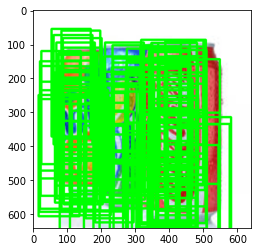

In [327]:
import matplotlib.pyplot as plt
import cv2

image_with_bounding_box = img.numpy()

for i in range(bboxes.shape[0]):
#for i in range(2):
    image_with_bounding_box = cv2.rectangle(image_with_bounding_box, (int(bboxes[i,0]), int(bboxes[i,1])), (int(bboxes[i,2]), int(bboxes[i,3])), (0, 255, 0), 5)
plt.imshow(image_with_bounding_box)

### option 2

In [10]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [11]:
from RPN import RPN

model = RPN(9  , range_positive=0.5,
                 range_negative=0.1,
                 scales=np.array([0.5, 1, 2]),
                 dims=np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]))
model.build((None, 20, 20, 512))
model.compile(
    optimizer=tf.keras.optimizers.Adam()
)

history = model.fit(res, bbox, batch_size=1, epochs=5000, callbacks = [tensorboard_callback])

Epoch 1/5000
1/8 [==>...........................] - ETA: 0s - loss: 17.7557 - class_loss: 3.3831 - l1_loss: 1.4373WARNING:tensorflow:From C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8/8 [==============================] - 0s 47ms/step - loss: 73.6126 - class_loss: 5.1052 - l1_loss: 6.8507
Epoch 2/5000
8/8 [==============================] - 0s 28ms/step - loss: 99.5895 - class_loss: 0.4353 - l1_loss: 9.9154
Epoch 3/5000
8/8 [==============================] - 0s 27ms/step - loss: 64.4072 - class_loss: 0.3378 - l1_loss: 6.4069
Epoch 4/5000
8/8 [==============================] - 0s 28ms/step - loss: 77.2240 - class_loss: 0.3067 - l1_loss: 7.6917
Epoch 5/5000
8/8 [==============================] - 0s 28ms/step - loss: 45.2204 - class_loss: 0.3013 - l1_loss: 4.4919
Epoch

8/8 [==============================] - 0s 29ms/step - loss: 1.8278 - class_loss: 0.0302 - l1_loss: 0.1798
Epoch 130/5000
8/8 [==============================] - 0s 29ms/step - loss: 2.8169 - class_loss: 0.0590 - l1_loss: 0.2758
Epoch 131/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.7575 - class_loss: 0.1191 - l1_loss: 0.1638
Epoch 132/5000
8/8 [==============================] - 0s 27ms/step - loss: 2.5978 - class_loss: 0.0285 - l1_loss: 0.2569
Epoch 133/5000
8/8 [==============================] - 0s 28ms/step - loss: 2.7550 - class_loss: 0.1029 - l1_loss: 0.2652
Epoch 134/5000
8/8 [==============================] - 0s 28ms/step - loss: 3.4371 - class_loss: 0.0492 - l1_loss: 0.3388
Epoch 135/5000
8/8 [==============================] - 0s 28ms/step - loss: 2.7091 - class_loss: 0.1020 - l1_loss: 0.2607
Epoch 136/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.9347 - class_loss: 0.0991 - l1_loss: 0.2836
Epoch 137/5000
8/8 [===========================

8/8 [==============================] - 0s 30ms/step - loss: 1.5510 - class_loss: 0.0078 - l1_loss: 0.1543
Epoch 263/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.6790 - class_loss: 0.0068 - l1_loss: 0.1672
Epoch 264/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.0373 - class_loss: 0.0128 - l1_loss: 0.2025
Epoch 265/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.2338 - class_loss: 0.0195 - l1_loss: 0.2214
Epoch 266/5000
8/8 [==============================] - 0s 28ms/step - loss: 2.4863 - class_loss: 0.0212 - l1_loss: 0.2465
Epoch 267/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.1060 - class_loss: 0.0141 - l1_loss: 0.4092
Epoch 268/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.8020 - class_loss: 0.0196 - l1_loss: 0.4782
Epoch 269/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.7511 - class_loss: 0.0108 - l1_loss: 0.2740
Epoch 270/5000
8/8 [===========================

8/8 [==============================] - 0s 31ms/step - loss: 2.1189 - class_loss: 0.0100 - l1_loss: 0.2109
Epoch 393/5000
8/8 [==============================] - 0s 29ms/step - loss: 3.2575 - class_loss: 0.0141 - l1_loss: 0.3243 0s - loss: 3.4199 - class_loss: 0.0048 - l1_loss: 0.
Epoch 394/5000
8/8 [==============================] - 0s 29ms/step - loss: 2.2968 - class_loss: 0.0180 - l1_loss: 0.2279
Epoch 395/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.5939 - class_loss: 0.0042 - l1_loss: 0.2590
Epoch 396/5000
8/8 [==============================] - 0s 29ms/step - loss: 2.5788 - class_loss: 0.0147 - l1_loss: 0.2564
Epoch 397/5000
8/8 [==============================] - 0s 29ms/step - loss: 3.9321 - class_loss: 0.0333 - l1_loss: 0.3899
Epoch 398/5000
8/8 [==============================] - 0s 29ms/step - loss: 3.8511 - class_loss: 0.0109 - l1_loss: 0.3840
Epoch 399/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.6329 - class_loss: 0.0128 - l1_loss: 0

8/8 [==============================] - 0s 29ms/step - loss: 5.1426 - class_loss: 0.0035 - l1_loss: 0.5139
Epoch 525/5000
8/8 [==============================] - 0s 29ms/step - loss: 5.7291 - class_loss: 0.0172 - l1_loss: 0.5712
Epoch 526/5000
8/8 [==============================] - 0s 30ms/step - loss: 6.7109 - class_loss: 0.0255 - l1_loss: 0.6685
Epoch 527/5000
8/8 [==============================] - 0s 29ms/step - loss: 5.6149 - class_loss: 0.0119 - l1_loss: 0.5603
Epoch 528/5000
8/8 [==============================] - 0s 30ms/step - loss: 5.6493 - class_loss: 0.0047 - l1_loss: 0.5645
Epoch 529/5000
8/8 [==============================] - 0s 28ms/step - loss: 6.3065 - class_loss: 0.0197 - l1_loss: 0.6287
Epoch 530/5000
8/8 [==============================] - 0s 30ms/step - loss: 8.0702 - class_loss: 0.0068 - l1_loss: 0.8063
Epoch 531/5000
8/8 [==============================] - 0s 30ms/step - loss: 7.2845 - class_loss: 0.0059 - l1_loss: 0.7279
Epoch 532/5000
8/8 [===========================

8/8 [==============================] - 0s 29ms/step - loss: 3.4779 - class_loss: 0.0099 - l1_loss: 0.3468
Epoch 655/5000
8/8 [==============================] - 0s 29ms/step - loss: 3.8395 - class_loss: 0.0125 - l1_loss: 0.3827
Epoch 656/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.5826 - class_loss: 0.0086 - l1_loss: 0.3574
Epoch 657/5000
8/8 [==============================] - 0s 28ms/step - loss: 5.1846 - class_loss: 0.0566 - l1_loss: 0.5128
Epoch 658/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.8261 - class_loss: 0.0089 - l1_loss: 0.3817
Epoch 659/5000
8/8 [==============================] - 0s 32ms/step - loss: 3.5086 - class_loss: 0.0112 - l1_loss: 0.3497
Epoch 660/5000
8/8 [==============================] - 0s 31ms/step - loss: 3.6000 - class_loss: 0.0130 - l1_loss: 0.3587
Epoch 661/5000
8/8 [==============================] - 0s 29ms/step - loss: 2.7550 - class_loss: 0.0093 - l1_loss: 0.2746
Epoch 662/5000
8/8 [===========================

8/8 [==============================] - 0s 31ms/step - loss: 5.6947 - class_loss: 0.0268 - l1_loss: 0.5668
Epoch 788/5000
8/8 [==============================] - 0s 29ms/step - loss: 5.2364 - class_loss: 0.0557 - l1_loss: 0.5181
Epoch 789/5000
8/8 [==============================] - 0s 31ms/step - loss: 7.5081 - class_loss: 0.0027 - l1_loss: 0.7505
Epoch 790/5000
8/8 [==============================] - 0s 30ms/step - loss: 5.7753 - class_loss: 0.0148 - l1_loss: 0.5761
Epoch 791/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.6685 - class_loss: 0.0114 - l1_loss: 0.4657
Epoch 792/5000
8/8 [==============================] - 0s 28ms/step - loss: 5.3150 - class_loss: 0.0083 - l1_loss: 0.5307
Epoch 793/5000
8/8 [==============================] - 0s 28ms/step - loss: 6.3441 - class_loss: 0.0182 - l1_loss: 0.6326
Epoch 794/5000
8/8 [==============================] - 0s 29ms/step - loss: 5.8154 - class_loss: 0.0488 - l1_loss: 0.5767
Epoch 795/5000
8/8 [===========================

8/8 [==============================] - 0s 31ms/step - loss: 11.9976 - class_loss: 0.0035 - l1_loss: 1.1994
Epoch 918/5000
8/8 [==============================] - 0s 32ms/step - loss: 21.5340 - class_loss: 0.0091 - l1_loss: 2.1525
Epoch 919/5000
8/8 [==============================] - 0s 30ms/step - loss: 19.8556 - class_loss: 0.0762 - l1_loss: 1.9779
Epoch 920/5000
8/8 [==============================] - 0s 32ms/step - loss: 36.8797 - class_loss: 0.0046 - l1_loss: 3.6875
Epoch 921/5000
8/8 [==============================] - 0s 32ms/step - loss: 33.0425 - class_loss: 0.0209 - l1_loss: 3.3022
Epoch 922/5000
8/8 [==============================] - 0s 32ms/step - loss: 24.0979 - class_loss: 0.0196 - l1_loss: 2.4078
Epoch 923/5000
8/8 [==============================] - 0s 32ms/step - loss: 31.9230 - class_loss: 0.0076 - l1_loss: 3.1915
Epoch 924/5000
8/8 [==============================] - 0s 32ms/step - loss: 20.6469 - class_loss: 0.0404 - l1_loss: 2.0606
Epoch 925/5000
8/8 [===================

8/8 [==============================] - 0s 29ms/step - loss: 3.6613 - class_loss: 0.0250 - l1_loss: 0.3636
Epoch 1049/5000
8/8 [==============================] - 0s 29ms/step - loss: 4.5459 - class_loss: 0.0054 - l1_loss: 0.4541
Epoch 1050/5000
8/8 [==============================] - 0s 31ms/step - loss: 5.9588 - class_loss: 0.0025 - l1_loss: 0.5956
Epoch 1051/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.8443 - class_loss: 0.0364 - l1_loss: 0.4808
Epoch 1052/5000
8/8 [==============================] - 0s 31ms/step - loss: 5.8852 - class_loss: 0.0073 - l1_loss: 0.5878
Epoch 1053/5000
8/8 [==============================] - 0s 29ms/step - loss: 5.4484 - class_loss: 0.0041 - l1_loss: 0.5444
Epoch 1054/5000
8/8 [==============================] - 0s 29ms/step - loss: 7.2853 - class_loss: 0.0103 - l1_loss: 0.7275
Epoch 1055/5000
8/8 [==============================] - 0s 29ms/step - loss: 9.6180 - class_loss: 0.0094 - l1_loss: 0.9609
Epoch 1056/5000
8/8 [===================

8/8 [==============================] - 0s 28ms/step - loss: 3.6281 - class_loss: 0.0115 - l1_loss: 0.3617
Epoch 1179/5000
8/8 [==============================] - 0s 29ms/step - loss: 3.0791 - class_loss: 0.0052 - l1_loss: 0.3074
Epoch 1180/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.9430 - class_loss: 0.0020 - l1_loss: 0.4941
Epoch 1181/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.4605 - class_loss: 0.0015 - l1_loss: 0.3459
Epoch 1182/5000
8/8 [==============================] - 0s 29ms/step - loss: 5.6257 - class_loss: 0.0026 - l1_loss: 0.5623ETA: 0s - loss: 6.2830 - class_loss: 0.0022 - l1_loss: 0.
Epoch 1183/5000
8/8 [==============================] - 0s 29ms/step - loss: 4.2011 - class_loss: 0.0041 - l1_loss: 0.4197
Epoch 1184/5000
8/8 [==============================] - 0s 30ms/step - loss: 6.7134 - class_loss: 0.0091 - l1_loss: 0.6704
Epoch 1185/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.9976 - class_loss: 0.0149 -

Epoch 1305/5000
8/8 [==============================] - 0s 32ms/step - loss: 2.5870 - class_loss: 0.0085 - l1_loss: 0.2579
Epoch 1306/5000
8/8 [==============================] - 0s 32ms/step - loss: 2.2578 - class_loss: 0.0074 - l1_loss: 0.2250
Epoch 1307/5000
8/8 [==============================] - 0s 33ms/step - loss: 2.7058 - class_loss: 0.0091 - l1_loss: 0.2697
Epoch 1308/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.6210 - class_loss: 0.0209 - l1_loss: 0.2600
Epoch 1309/5000
8/8 [==============================] - 0s 32ms/step - loss: 2.9054 - class_loss: 0.0178 - l1_loss: 0.2888
Epoch 1310/5000
8/8 [==============================] - 0s 34ms/step - loss: 3.8537 - class_loss: 0.0022 - l1_loss: 0.3852
Epoch 1311/5000
8/8 [==============================] - 0s 34ms/step - loss: 5.1075 - class_loss: 0.0040 - l1_loss: 0.5103
Epoch 1312/5000
8/8 [==============================] - 0s 33ms/step - loss: 5.0057 - class_loss: 0.0051 - l1_loss: 0.5001
Epoch 1313/5000
8/8 [===

8/8 [==============================] - 0s 30ms/step - loss: 1.7320 - class_loss: 0.0071 - l1_loss: 0.1725
Epoch 1436/5000
8/8 [==============================] - 0s 31ms/step - loss: 1.9194 - class_loss: 0.0110 - l1_loss: 0.1908
Epoch 1437/5000
8/8 [==============================] - 0s 29ms/step - loss: 2.0375 - class_loss: 0.0046 - l1_loss: 0.2033
Epoch 1438/5000
8/8 [==============================] - 0s 29ms/step - loss: 2.3825 - class_loss: 0.0014 - l1_loss: 0.2381
Epoch 1439/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.2435 - class_loss: 0.0022 - l1_loss: 0.2241
Epoch 1440/5000
8/8 [==============================] - 0s 31ms/step - loss: 1.8334 - class_loss: 0.0011 - l1_loss: 0.1832
Epoch 1441/5000
8/8 [==============================] - 0s 28ms/step - loss: 1.7042 - class_loss: 0.0013 - l1_loss: 0.1703ETA: 0s - loss: 1.7987 - class_loss: 0.0015 - l1_loss: 0.1797
Epoch 1442/5000
8/8 [==============================] - 0s 29ms/step - loss: 1.7828 - class_loss: 0.00

8/8 [==============================] - 0s 31ms/step - loss: 10.8386 - class_loss: 7.1687e-04 - l1_loss: 1.0838
Epoch 1565/5000
8/8 [==============================] - 0s 29ms/step - loss: 10.6614 - class_loss: 0.0018 - l1_loss: 1.0660
Epoch 1566/5000
8/8 [==============================] - 0s 28ms/step - loss: 11.2777 - class_loss: 0.0160 - l1_loss: 1.1262
Epoch 1567/5000
8/8 [==============================] - 0s 28ms/step - loss: 9.3661 - class_loss: 0.0033 - l1_loss: 0.9363
Epoch 1568/5000
8/8 [==============================] - 0s 30ms/step - loss: 10.8270 - class_loss: 0.0831 - l1_loss: 1.0744
Epoch 1569/5000
8/8 [==============================] - 0s 29ms/step - loss: 11.1643 - class_loss: 9.9028e-04 - l1_loss: 1.1163
Epoch 1570/5000
8/8 [==============================] - 0s 29ms/step - loss: 10.8118 - class_loss: 3.0273e-04 - l1_loss: 1.0811
Epoch 1571/5000
8/8 [==============================] - 0s 30ms/step - loss: 10.7031 - class_loss: 4.7303e-04 - l1_loss: 1.0703
Epoch 1572/5000
8

8/8 [==============================] - 0s 30ms/step - loss: 3.4596 - class_loss: 0.0018 - l1_loss: 0.3458
Epoch 1693/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.3125 - class_loss: 0.0021 - l1_loss: 0.3310
Epoch 1694/5000
8/8 [==============================] - 0s 27ms/step - loss: 3.9474 - class_loss: 0.0019 - l1_loss: 0.3945
Epoch 1695/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.5307 - class_loss: 0.0206 - l1_loss: 0.3510
Epoch 1696/5000
8/8 [==============================] - 0s 31ms/step - loss: 3.2592 - class_loss: 0.0040 - l1_loss: 0.3255
Epoch 1697/5000
8/8 [==============================] - 0s 31ms/step - loss: 3.6934 - class_loss: 0.0019 - l1_loss: 0.3692
Epoch 1698/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.8904 - class_loss: 0.0025 - l1_loss: 0.2888
Epoch 1699/5000
8/8 [==============================] - 0s 31ms/step - loss: 3.7787 - class_loss: 0.0074 - l1_loss: 0.3771
Epoch 1700/5000
8/8 [===================

Epoch 1759/5000
8/8 [==============================] - 0s 32ms/step - loss: 10.4524 - class_loss: 0.0033 - l1_loss: 1.0449
Epoch 1760/5000
8/8 [==============================] - 0s 33ms/step - loss: 10.5796 - class_loss: 0.0025 - l1_loss: 1.0577
Epoch 1761/5000
8/8 [==============================] - 0s 31ms/step - loss: 9.7256 - class_loss: 0.0023 - l1_loss: 0.9723
Epoch 1762/5000
8/8 [==============================] - 0s 31ms/step - loss: 9.2342 - class_loss: 0.0041 - l1_loss: 0.9230
Epoch 1763/5000
8/8 [==============================] - 0s 32ms/step - loss: 9.3261 - class_loss: 0.0410 - l1_loss: 0.9285
Epoch 1764/5000
8/8 [==============================] - 0s 32ms/step - loss: 11.6104 - class_loss: 0.0350 - l1_loss: 1.1575
Epoch 1765/5000
8/8 [==============================] - 0s 31ms/step - loss: 13.3667 - class_loss: 0.0013 - l1_loss: 1.3365
Epoch 1766/5000
8/8 [==============================] - 0s 31ms/step - loss: 10.2485 - class_loss: 0.0028 - l1_loss: 1.0246
Epoch 1767/5000
8/8

8/8 [==============================] - 0s 28ms/step - loss: 3.6126 - class_loss: 0.0062 - l1_loss: 0.3606
Epoch 1889/5000
8/8 [==============================] - 0s 29ms/step - loss: 3.9728 - class_loss: 0.0248 - l1_loss: 0.3948
Epoch 1890/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.2866 - class_loss: 6.9344e-04 - l1_loss: 0.3286
Epoch 1891/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.6474 - class_loss: 0.0013 - l1_loss: 0.2646
Epoch 1892/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.6698 - class_loss: 0.0036 - l1_loss: 0.2666
Epoch 1893/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.8849 - class_loss: 0.0111 - l1_loss: 0.1874
Epoch 1894/5000
8/8 [==============================] - 0s 29ms/step - loss: 1.7271 - class_loss: 0.0111 - l1_loss: 0.1716
Epoch 1895/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.7875 - class_loss: 0.0044 - l1_loss: 0.1783
Epoch 1896/5000
8/8 [===============

8/8 [==============================] - 0s 28ms/step - loss: 0.5223 - class_loss: 0.0036 - l1_loss: 0.0519
Epoch 1954/5000
8/8 [==============================] - 0s 29ms/step - loss: 0.6606 - class_loss: 0.0027 - l1_loss: 0.0658 0s - loss: 0.6829 - class_loss: 0.0040 - l1_loss: 
Epoch 1955/5000
8/8 [==============================] - 0s 28ms/step - loss: 0.5948 - class_loss: 0.0032 - l1_loss: 0.0592
Epoch 1956/5000
8/8 [==============================] - 0s 30ms/step - loss: 0.5757 - class_loss: 0.0036 - l1_loss: 0.0572
Epoch 1957/5000
8/8 [==============================] - 0s 29ms/step - loss: 0.4558 - class_loss: 0.0035 - l1_loss: 0.0452
Epoch 1958/5000
8/8 [==============================] - 0s 28ms/step - loss: 0.7755 - class_loss: 0.0032 - l1_loss: 0.0772
Epoch 1959/5000
8/8 [==============================] - 0s 29ms/step - loss: 0.5704 - class_loss: 0.0036 - l1_loss: 0.0567 0s - loss: 0.5756 - class_loss: 0.0048 - l1_loss: 0.
Epoch 1960/5000
8/8 [==============================] - 0s 

8/8 [==============================] - 0s 30ms/step - loss: 3.3408 - class_loss: 0.0070 - l1_loss: 0.3334
Epoch 2085/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.2050 - class_loss: 0.0015 - l1_loss: 0.2204
Epoch 2086/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.1367 - class_loss: 8.1635e-04 - l1_loss: 0.2136
Epoch 2087/5000
8/8 [==============================] - 0s 29ms/step - loss: 1.4820 - class_loss: 0.0092 - l1_loss: 0.1473
Epoch 2088/5000
8/8 [==============================] - 0s 32ms/step - loss: 1.6685 - class_loss: 0.0128 - l1_loss: 0.1656
Epoch 2089/5000
8/8 [==============================] - 0s 31ms/step - loss: 1.5118 - class_loss: 0.0045 - l1_loss: 0.1507
Epoch 2090/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.3692 - class_loss: 0.0036 - l1_loss: 0.1366
Epoch 2091/5000
8/8 [==============================] - 0s 32ms/step - loss: 1.6452 - class_loss: 0.0073 - l1_loss: 0.1638
Epoch 2092/5000
8/8 [===============

8/8 [==============================] - 0s 30ms/step - loss: 17.0319 - class_loss: 0.0089 - l1_loss: 1.7023
Epoch 2218/5000
8/8 [==============================] - 0s 29ms/step - loss: 12.4373 - class_loss: 0.0090 - l1_loss: 1.2428
Epoch 2219/5000
8/8 [==============================] - 0s 30ms/step - loss: 12.6837 - class_loss: 0.0048 - l1_loss: 1.2679
Epoch 2220/5000
8/8 [==============================] - 0s 30ms/step - loss: 13.5494 - class_loss: 0.0027 - l1_loss: 1.3547
Epoch 2221/5000
8/8 [==============================] - 0s 31ms/step - loss: 10.5471 - class_loss: 0.0072 - l1_loss: 1.0540
Epoch 2222/5000
8/8 [==============================] - 0s 29ms/step - loss: 12.6582 - class_loss: 0.0067 - l1_loss: 1.2651
Epoch 2223/5000
8/8 [==============================] - 0s 30ms/step - loss: 10.4879 - class_loss: 0.0022 - l1_loss: 1.0486
Epoch 2224/5000
8/8 [==============================] - 0s 31ms/step - loss: 11.3026 - class_loss: 0.0050 - l1_loss: 1.1298
Epoch 2225/5000
8/8 [===========

Epoch 2348/5000
8/8 [==============================] - 0s 30ms/step - loss: 12.3694 - class_loss: 0.0014 - l1_loss: 1.2368
Epoch 2349/5000
8/8 [==============================] - 0s 29ms/step - loss: 7.4615 - class_loss: 0.0027 - l1_loss: 0.7459
Epoch 2350/5000
8/8 [==============================] - 0s 29ms/step - loss: 8.4275 - class_loss: 0.0024 - l1_loss: 0.8425ETA: 0s - loss: 7.6841 - class_loss: 0.0050 - l1_loss: 0.76
Epoch 2351/5000
8/8 [==============================] - 0s 31ms/step - loss: 10.3987 - class_loss: 0.0024 - l1_loss: 1.0396
Epoch 2352/5000
8/8 [==============================] - 0s 28ms/step - loss: 17.3644 - class_loss: 0.3862 - l1_loss: 1.6978
Epoch 2353/5000
8/8 [==============================] - 0s 29ms/step - loss: 19.0358 - class_loss: 0.2835 - l1_loss: 1.8752
Epoch 2354/5000
8/8 [==============================] - 0s 29ms/step - loss: 26.2030 - class_loss: 0.2445 - l1_loss: 2.5958
Epoch 2355/5000
8/8 [==============================] - 0s 28ms/step - loss: 28.246

8/8 [==============================] - 0s 32ms/step - loss: 9.1305 - class_loss: 0.0348 - l1_loss: 0.9096
Epoch 2479/5000
8/8 [==============================] - 0s 29ms/step - loss: 5.9681 - class_loss: 0.0010 - l1_loss: 0.5967
Epoch 2480/5000
8/8 [==============================] - 0s 28ms/step - loss: 6.9750 - class_loss: 0.0136 - l1_loss: 0.6961
Epoch 2481/5000
8/8 [==============================] - 0s 30ms/step - loss: 6.1048 - class_loss: 0.0166 - l1_loss: 0.6088
Epoch 2482/5000
8/8 [==============================] - 0s 32ms/step - loss: 6.2486 - class_loss: 0.0011 - l1_loss: 0.6248
Epoch 2483/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.6003 - class_loss: 3.1693e-04 - l1_loss: 0.4600
Epoch 2484/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.4805 - class_loss: 0.0030 - l1_loss: 0.3477
Epoch 2485/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.6835 - class_loss: 0.0019 - l1_loss: 0.4682
Epoch 2486/5000
8/8 [===============

8/8 [==============================] - 0s 31ms/step - loss: 9.1862 - class_loss: 0.0032 - l1_loss: 0.9183
Epoch 2611/5000
8/8 [==============================] - 0s 28ms/step - loss: 10.4644 - class_loss: 0.0050 - l1_loss: 1.0459
Epoch 2612/5000
8/8 [==============================] - 0s 32ms/step - loss: 6.5773 - class_loss: 0.0023 - l1_loss: 0.6575
Epoch 2613/5000
8/8 [==============================] - 0s 29ms/step - loss: 6.7385 - class_loss: 0.0015 - l1_loss: 0.6737 0s - loss: 6.8591 - class_loss: 0.0017 - l1_loss: 0.
Epoch 2614/5000
8/8 [==============================] - 0s 29ms/step - loss: 9.7669 - class_loss: 0.0121 - l1_loss: 0.9755
Epoch 2615/5000
8/8 [==============================] - 0s 28ms/step - loss: 6.6331 - class_loss: 0.0035 - l1_loss: 0.6630
Epoch 2616/5000
8/8 [==============================] - 0s 30ms/step - loss: 9.0249 - class_loss: 0.0029 - l1_loss: 0.9022
Epoch 2617/5000
8/8 [==============================] - 0s 31ms/step - loss: 6.5386 - class_loss: 0.0012 - l1

Epoch 2742/5000
8/8 [==============================] - 0s 31ms/step - loss: 6.6133 - class_loss: 0.0161 - l1_loss: 0.6597
Epoch 2743/5000
8/8 [==============================] - 0s 30ms/step - loss: 6.4416 - class_loss: 0.0046 - l1_loss: 0.6437
Epoch 2744/5000
8/8 [==============================] - 0s 30ms/step - loss: 7.5571 - class_loss: 0.0101 - l1_loss: 0.7547
Epoch 2745/5000
8/8 [==============================] - 0s 31ms/step - loss: 6.4481 - class_loss: 4.5098e-04 - l1_loss: 0.6448
Epoch 2746/5000
8/8 [==============================] - 0s 30ms/step - loss: 5.2285 - class_loss: 0.0015 - l1_loss: 0.5227
Epoch 2747/5000
8/8 [==============================] - 0s 30ms/step - loss: 5.1704 - class_loss: 0.0061 - l1_loss: 0.5164
Epoch 2748/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.3265 - class_loss: 0.0016 - l1_loss: 0.4325
Epoch 2749/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.9606 - class_loss: 9.2755e-04 - l1_loss: 0.3960
Epoch 2750/5000


8/8 [==============================] - 0s 31ms/step - loss: 1.7217 - class_loss: 0.0013 - l1_loss: 0.1720
Epoch 2872/5000
8/8 [==============================] - 0s 32ms/step - loss: 1.8810 - class_loss: 0.0035 - l1_loss: 0.1878
Epoch 2873/5000
8/8 [==============================] - 0s 29ms/step - loss: 1.6561 - class_loss: 0.0018 - l1_loss: 0.1654
Epoch 2874/5000
8/8 [==============================] - 0s 28ms/step - loss: 1.6754 - class_loss: 6.2247e-04 - l1_loss: 0.1675
Epoch 2875/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.2860 - class_loss: 0.0032 - l1_loss: 0.1283
Epoch 2876/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.1141 - class_loss: 0.0026 - l1_loss: 0.1112
Epoch 2877/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.2949 - class_loss: 5.0215e-04 - l1_loss: 0.1294
Epoch 2878/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.2280 - class_loss: 0.0021 - l1_loss: 0.1226
Epoch 2879/5000
8/8 [===========

8/8 [==============================] - 0s 32ms/step - loss: 2.5329 - class_loss: 0.0061 - l1_loss: 0.2527
Epoch 3003/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.2596 - class_loss: 0.0031 - l1_loss: 0.2257
Epoch 3004/5000
8/8 [==============================] - 0s 32ms/step - loss: 2.9170 - class_loss: 6.2964e-04 - l1_loss: 0.2916
Epoch 3005/5000
8/8 [==============================] - 0s 34ms/step - loss: 2.8736 - class_loss: 0.0014 - l1_loss: 0.2872
Epoch 3006/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.5704 - class_loss: 0.0047 - l1_loss: 0.2566
Epoch 3007/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.6573 - class_loss: 0.0040 - l1_loss: 0.2653
Epoch 3008/5000
8/8 [==============================] - 0s 31ms/step - loss: 3.6078 - class_loss: 0.0103 - l1_loss: 0.3597
Epoch 3009/5000
8/8 [==============================] - 0s 32ms/step - loss: 3.1023 - class_loss: 0.0040 - l1_loss: 0.3098
Epoch 3010/5000
8/8 [===============

8/8 [==============================] - 0s 28ms/step - loss: 56.4003 - class_loss: 0.0053 - l1_loss: 5.6395 ETA: 0s - loss: 60.0574 - class_loss: 0.0060 - l1_loss: 6.005
Epoch 3132/5000
8/8 [==============================] - 0s 30ms/step - loss: 72.5650 - class_loss: 0.0161 - l1_loss: 7.2549
Epoch 3133/5000
8/8 [==============================] - 0s 29ms/step - loss: 106.5863 - class_loss: 0.2987 - l1_loss: 10.6288
Epoch 3134/5000
8/8 [==============================] - 0s 28ms/step - loss: 68.9177 - class_loss: 0.0745 - l1_loss: 6.8843
Epoch 3135/5000
8/8 [==============================] - 0s 28ms/step - loss: 60.3780 - class_loss: 0.0019 - l1_loss: 6.0376
Epoch 3136/5000
8/8 [==============================] - 0s 29ms/step - loss: 43.4218 - class_loss: 0.0015 - l1_loss: 4.3420
Epoch 3137/5000
8/8 [==============================] - 0s 29ms/step - loss: 29.8681 - class_loss: 1.2943e-04 - l1_loss: 2.9868: 0s - loss: 29.8681 - class_loss: 1.2943e-04 - l1_loss: 2.986
Epoch 3138/5000
8/8 [====

8/8 [==============================] - 0s 32ms/step - loss: 7.5575 - class_loss: 7.5661e-04 - l1_loss: 0.7557
Epoch 3261/5000
8/8 [==============================] - 0s 33ms/step - loss: 5.9265 - class_loss: 6.6678e-04 - l1_loss: 0.5926
Epoch 3262/5000
8/8 [==============================] - 0s 34ms/step - loss: 9.1753 - class_loss: 0.0034 - l1_loss: 0.9172
Epoch 3263/5000
8/8 [==============================] - 0s 33ms/step - loss: 10.5504 - class_loss: 0.0104 - l1_loss: 1.0540
Epoch 3264/5000
8/8 [==============================] - 0s 31ms/step - loss: 10.4233 - class_loss: 0.0027 - l1_loss: 1.0421
Epoch 3265/5000
8/8 [==============================] - 0s 32ms/step - loss: 9.7794 - class_loss: 0.0036 - l1_loss: 0.9776
Epoch 3266/5000
8/8 [==============================] - 0s 35ms/step - loss: 10.3371 - class_loss: 0.0034 - l1_loss: 1.0334
Epoch 3267/5000
8/8 [==============================] - 0s 33ms/step - loss: 9.7888 - class_loss: 0.0127 - l1_loss: 0.9776
Epoch 3268/5000
8/8 [========

8/8 [==============================] - 0s 33ms/step - loss: 3.3072 - class_loss: 0.0156 - l1_loss: 0.3292
Epoch 3390/5000
8/8 [==============================] - 0s 33ms/step - loss: 3.0210 - class_loss: 0.0031 - l1_loss: 0.3018
Epoch 3391/5000
8/8 [==============================] - 0s 35ms/step - loss: 2.4184 - class_loss: 0.0041 - l1_loss: 0.2414
Epoch 3392/5000
8/8 [==============================] - 0s 33ms/step - loss: 2.1019 - class_loss: 0.0220 - l1_loss: 0.2080
Epoch 3393/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.4414 - class_loss: 5.8206e-04 - l1_loss: 0.2441
Epoch 3394/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.5665 - class_loss: 2.0664e-04 - l1_loss: 0.2566
Epoch 3395/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.5333 - class_loss: 0.0031 - l1_loss: 0.2530
Epoch 3396/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.8123 - class_loss: 0.0016 - l1_loss: 0.2811
Epoch 3397/5000
8/8 [===========

Epoch 3456/5000
8/8 [==============================] - 0s 32ms/step - loss: 2.0224 - class_loss: 6.9315e-04 - l1_loss: 0.2022
Epoch 3457/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.9483 - class_loss: 6.5601e-04 - l1_loss: 0.1948
Epoch 3458/5000
8/8 [==============================] - 0s 32ms/step - loss: 1.8730 - class_loss: 0.0040 - l1_loss: 0.1869
Epoch 3459/5000
8/8 [==============================] - ETA: 0s - loss: 3.1582 - class_loss: 0.0106 - l1_loss: 0.31 - 0s 34ms/step - loss: 3.0652 - class_loss: 0.0096 - l1_loss: 0.3056
Epoch 3460/5000
8/8 [==============================] - 0s 33ms/step - loss: 2.9861 - class_loss: 8.0727e-04 - l1_loss: 0.2985
Epoch 3461/5000
8/8 [==============================] - 0s 35ms/step - loss: 3.2032 - class_loss: 0.0034 - l1_loss: 0.3200
Epoch 3462/5000
8/8 [==============================] - 0s 41ms/step - loss: 2.9884 - class_loss: 0.0011 - l1_loss: 0.2987
Epoch 3463/5000
8/8 [==============================] - 0s 33ms/step - lo

8/8 [==============================] - 0s 30ms/step - loss: 15.6154 - class_loss: 0.0052 - l1_loss: 1.5610: 0s - loss: 15.5600 - class_loss: 0.0017 - l1_loss: 1.555
Epoch 3585/5000
8/8 [==============================] - 0s 31ms/step - loss: 19.4509 - class_loss: 0.0033 - l1_loss: 1.9448
Epoch 3586/5000
8/8 [==============================] - 0s 31ms/step - loss: 14.6210 - class_loss: 0.0029 - l1_loss: 1.4618
Epoch 3587/5000
8/8 [==============================] - 0s 31ms/step - loss: 11.5073 - class_loss: 0.0128 - l1_loss: 1.1495
Epoch 3588/5000
8/8 [==============================] - 0s 29ms/step - loss: 19.7280 - class_loss: 2.2067e-04 - l1_loss: 1.9728
Epoch 3589/5000
8/8 [==============================] - 0s 30ms/step - loss: 10.7527 - class_loss: 4.1433e-04 - l1_loss: 1.0752
Epoch 3590/5000
8/8 [==============================] - 0s 29ms/step - loss: 9.0443 - class_loss: 8.6524e-04 - l1_loss: 0.9043
Epoch 3591/5000
8/8 [==============================] - 0s 31ms/step - loss: 9.5379 - c

8/8 [==============================] - 0s 35ms/step - loss: 17.8029 - class_loss: 0.0093 - l1_loss: 1.7794
Epoch 3711/5000
8/8 [==============================] - 0s 30ms/step - loss: 12.3497 - class_loss: 1.4981e-04 - l1_loss: 1.2350
Epoch 3712/5000
8/8 [==============================] - 0s 32ms/step - loss: 16.3132 - class_loss: 8.6712e-04 - l1_loss: 1.6312
Epoch 3713/5000
8/8 [==============================] - 0s 29ms/step - loss: 16.0297 - class_loss: 7.3132e-04 - l1_loss: 1.6029
Epoch 3714/5000
8/8 [==============================] - 0s 31ms/step - loss: 12.3945 - class_loss: 0.0030 - l1_loss: 1.2392
Epoch 3715/5000
8/8 [==============================] - 0s 31ms/step - loss: 8.9555 - class_loss: 0.0645 - l1_loss: 0.8891
Epoch 3716/5000
8/8 [==============================] - 0s 31ms/step - loss: 10.9040 - class_loss: 0.0013 - l1_loss: 1.0903
Epoch 3717/5000
8/8 [==============================] - 0s 30ms/step - loss: 8.7244 - class_loss: 7.7381e-04 - l1_loss: 0.8724
Epoch 3718/5000
8/

8/8 [==============================] - 0s 32ms/step - loss: 10.4347 - class_loss: 0.0044 - l1_loss: 1.0430
Epoch 3843/5000
8/8 [==============================] - 0s 30ms/step - loss: 13.2638 - class_loss: 5.9908e-04 - l1_loss: 1.3263
Epoch 3844/5000
8/8 [==============================] - 0s 28ms/step - loss: 8.5320 - class_loss: 0.0011 - l1_loss: 0.8531
Epoch 3845/5000
8/8 [==============================] - 0s 29ms/step - loss: 7.2506 - class_loss: 0.0252 - l1_loss: 0.7225
Epoch 3846/5000
8/8 [==============================] - 0s 30ms/step - loss: 11.0556 - class_loss: 0.0120 - l1_loss: 1.1044
Epoch 3847/5000
8/8 [==============================] - 0s 29ms/step - loss: 11.6363 - class_loss: 0.0032 - l1_loss: 1.1633
Epoch 3848/5000
8/8 [==============================] - 0s 30ms/step - loss: 10.8531 - class_loss: 0.0025 - l1_loss: 1.0851
Epoch 3849/5000
8/8 [==============================] - 0s 30ms/step - loss: 10.6684 - class_loss: 0.0010 - l1_loss: 1.0667
Epoch 3850/5000
8/8 [=========

8/8 [==============================] - 0s 31ms/step - loss: 36.9585 - class_loss: 0.3370 - l1_loss: 3.6621
Epoch 3973/5000
8/8 [==============================] - 0s 29ms/step - loss: 36.7215 - class_loss: 0.0978 - l1_loss: 3.6624
Epoch 3974/5000
8/8 [==============================] - 0s 31ms/step - loss: 43.8344 - class_loss: 0.1219 - l1_loss: 4.3713: 0s - loss: 43.6464 - class_loss: 0.1363 - l1_loss: 4.351
Epoch 3975/5000
8/8 [==============================] - 0s 29ms/step - loss: 30.0014 - class_loss: 0.0092 - l1_loss: 2.9992: 0s - loss: 24.9700 - class_loss: 0.0216 - l1_loss: 2.4
Epoch 3976/5000
8/8 [==============================] - 0s 30ms/step - loss: 31.7267 - class_loss: 4.0301e-04 - l1_loss: 3.1726
Epoch 3977/5000
8/8 [==============================] - 0s 31ms/step - loss: 44.4803 - class_loss: 0.0105 - l1_loss: 4.4470
Epoch 3978/5000
8/8 [==============================] - 0s 30ms/step - loss: 36.9446 - class_loss: 0.0641 - l1_loss: 3.6880
Epoch 3979/5000
8/8 [================

8/8 [==============================] - 0s 30ms/step - loss: 0.7729 - class_loss: 7.8407e-04 - l1_loss: 0.0772
Epoch 4038/5000
8/8 [==============================] - 0s 29ms/step - loss: 0.9837 - class_loss: 9.0578e-04 - l1_loss: 0.0983
Epoch 4039/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.1496 - class_loss: 7.2031e-04 - l1_loss: 0.1149
Epoch 4040/5000
8/8 [==============================] - 0s 31ms/step - loss: 1.1204 - class_loss: 4.9530e-04 - l1_loss: 0.1120
Epoch 4041/5000
8/8 [==============================] - 0s 28ms/step - loss: 1.1007 - class_loss: 0.0012 - l1_loss: 0.1099
Epoch 4042/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.1010 - class_loss: 0.0022 - l1_loss: 0.1099
Epoch 4043/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.6759 - class_loss: 0.0020 - l1_loss: 0.1674
Epoch 4044/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.3754 - class_loss: 0.0010 - l1_loss: 0.1374
Epoch 4045/5000
8/8 [===

8/8 [==============================] - 0s 28ms/step - loss: 13.6046 - class_loss: 0.0040 - l1_loss: 1.3601
Epoch 4163/5000
8/8 [==============================] - 0s 28ms/step - loss: 13.7230 - class_loss: 0.0019 - l1_loss: 1.3721
Epoch 4164/5000
8/8 [==============================] - 0s 29ms/step - loss: 12.9110 - class_loss: 1.3748e-04 - l1_loss: 1.2911
Epoch 4165/5000
8/8 [==============================] - 0s 28ms/step - loss: 15.5062 - class_loss: 0.0018 - l1_loss: 1.5504
Epoch 4166/5000
8/8 [==============================] - 0s 30ms/step - loss: 11.5773 - class_loss: 1.9854e-04 - l1_loss: 1.1577: 0s - loss: 12.5155 - class_loss: 1.3225e-04 - l1_loss: 1.25
Epoch 4167/5000
8/8 [==============================] - 0s 31ms/step - loss: 8.5322 - class_loss: 0.0527 - l1_loss: 0.8479
Epoch 4168/5000
8/8 [==============================] - 0s 30ms/step - loss: 11.4365 - class_loss: 0.0187 - l1_loss: 1.1418
Epoch 4169/5000
8/8 [==============================] - 0s 31ms/step - loss: 12.2777 - c

8/8 [==============================] - 0s 33ms/step - loss: 4.8080 - class_loss: 0.0078 - l1_loss: 0.4800
Epoch 4293/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.0979 - class_loss: 8.2079e-04 - l1_loss: 0.4097
Epoch 4294/5000
8/8 [==============================] - 0s 32ms/step - loss: 5.6362 - class_loss: 0.0011 - l1_loss: 0.5635
Epoch 4295/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.9163 - class_loss: 9.8407e-04 - l1_loss: 0.4915
Epoch 4296/5000
8/8 [==============================] - 0s 30ms/step - loss: 4.3374 - class_loss: 1.2023e-04 - l1_loss: 0.4337
Epoch 4297/5000
8/8 [==============================] - 0s 32ms/step - loss: 4.9569 - class_loss: 0.0027 - l1_loss: 0.4954
Epoch 4298/5000
8/8 [==============================] - 0s 33ms/step - loss: 4.4929 - class_loss: 0.0147 - l1_loss: 0.4478
Epoch 4299/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.2915 - class_loss: 7.3677e-04 - l1_loss: 0.4291
Epoch 4300/5000
8/8 [===

8/8 [==============================] - 0s 31ms/step - loss: 2.3449 - class_loss: 5.7128e-04 - l1_loss: 0.2344
Epoch 4424/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.4585 - class_loss: 0.0013 - l1_loss: 0.1457
Epoch 4425/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.7140 - class_loss: 0.0014 - l1_loss: 0.2713
Epoch 4426/5000
8/8 [==============================] - 0s 31ms/step - loss: 1.7845 - class_loss: 0.0027 - l1_loss: 0.1782 0s - loss: 1.9686 - class_loss: 0.0020 - l1_loss: 
Epoch 4427/5000
8/8 [==============================] - 0s 31ms/step - loss: 1.3983 - class_loss: 0.0019 - l1_loss: 0.1396
Epoch 4428/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.3325 - class_loss: 0.0017 - l1_loss: 0.1331
Epoch 4429/5000
8/8 [==============================] - 0s 31ms/step - loss: 1.1318 - class_loss: 0.0027 - l1_loss: 0.1129
Epoch 4430/5000
8/8 [==============================] - 0s 30ms/step - loss: 0.9799 - class_loss: 0.0017 - l

8/8 [==============================] - 0s 29ms/step - loss: 0.9271 - class_loss: 6.9885e-04 - l1_loss: 0.0926
Epoch 4556/5000
8/8 [==============================] - 0s 32ms/step - loss: 0.9096 - class_loss: 0.0010 - l1_loss: 0.0909
Epoch 4557/5000
8/8 [==============================] - 0s 30ms/step - loss: 1.2888 - class_loss: 0.0011 - l1_loss: 0.1288
Epoch 4558/5000
8/8 [==============================] - 0s 32ms/step - loss: 0.9430 - class_loss: 0.0013 - l1_loss: 0.0942 0s - loss: 1.0015 - class_loss: 9.3044e-04 - l1_loss: 0.
Epoch 4559/5000
8/8 [==============================] - 0s 32ms/step - loss: 0.9270 - class_loss: 0.0027 - l1_loss: 0.0924
Epoch 4560/5000
8/8 [==============================] - 0s 32ms/step - loss: 0.8231 - class_loss: 0.0031 - l1_loss: 0.0820
Epoch 4561/5000
8/8 [==============================] - 0s 32ms/step - loss: 0.8085 - class_loss: 0.0030 - l1_loss: 0.0805
Epoch 4562/5000
8/8 [==============================] - 0s 31ms/step - loss: 0.8259 - class_loss: 0.00

8/8 [==============================] - 0s 29ms/step - loss: 3.1542 - class_loss: 0.0049 - l1_loss: 0.3149
Epoch 4686/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.7126 - class_loss: 0.0021 - l1_loss: 0.3710
Epoch 4687/5000
8/8 [==============================] - 0s 30ms/step - loss: 3.3615 - class_loss: 0.0032 - l1_loss: 0.3358
Epoch 4688/5000
8/8 [==============================] - 0s 29ms/step - loss: 2.4602 - class_loss: 0.0018 - l1_loss: 0.2458
Epoch 4689/5000
8/8 [==============================] - 0s 30ms/step - loss: 2.7420 - class_loss: 0.0024 - l1_loss: 0.2740
Epoch 4690/5000
8/8 [==============================] - 0s 28ms/step - loss: 2.9465 - class_loss: 0.0027 - l1_loss: 0.2944
Epoch 4691/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.7995 - class_loss: 0.0025 - l1_loss: 0.2797
Epoch 4692/5000
8/8 [==============================] - 0s 31ms/step - loss: 2.0640 - class_loss: 0.0013 - l1_loss: 0.2063
Epoch 4693/5000
8/8 [===================

8/8 [==============================] - 0s 31ms/step - loss: 4.8444 - class_loss: 8.6011e-05 - l1_loss: 0.4844
Epoch 4814/5000
8/8 [==============================] - 0s 31ms/step - loss: 5.0392 - class_loss: 8.5192e-05 - l1_loss: 0.5039
Epoch 4815/5000
8/8 [==============================] - 0s 30ms/step - loss: 8.0223 - class_loss: 0.0175 - l1_loss: 0.8005
Epoch 4816/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.9676 - class_loss: 8.9792e-04 - l1_loss: 0.4967
Epoch 4817/5000
8/8 [==============================] - 0s 31ms/step - loss: 6.4766 - class_loss: 1.8574e-04 - l1_loss: 0.6476
Epoch 4818/5000
8/8 [==============================] - 0s 31ms/step - loss: 4.5553 - class_loss: 3.3392e-05 - l1_loss: 0.4555
Epoch 4819/5000
8/8 [==============================] - 0s 29ms/step - loss: 4.8152 - class_loss: 3.4640e-04 - l1_loss: 0.4815
Epoch 4820/5000
8/8 [==============================] - 0s 29ms/step - loss: 4.4459 - class_loss: 0.0018 - l1_loss: 0.4444
Epoch 4821/5000


8/8 [==============================] - 0s 30ms/step - loss: 13.6511 - class_loss: 0.0290 - l1_loss: 1.3622
Epoch 4943/5000
8/8 [==============================] - 0s 28ms/step - loss: 10.2712 - class_loss: 0.0062 - l1_loss: 1.0265
Epoch 4944/5000
8/8 [==============================] - 0s 31ms/step - loss: 10.0590 - class_loss: 0.0032 - l1_loss: 1.0056
Epoch 4945/5000
8/8 [==============================] - 0s 28ms/step - loss: 5.9047 - class_loss: 0.0040 - l1_loss: 0.5901
Epoch 4946/5000
8/8 [==============================] - 0s 29ms/step - loss: 8.3836 - class_loss: 2.3582e-05 - l1_loss: 0.8384
Epoch 4947/5000
8/8 [==============================] - 0s 29ms/step - loss: 6.2029 - class_loss: 2.7481e-05 - l1_loss: 0.6203
Epoch 4948/5000
8/8 [==============================] - 0s 27ms/step - loss: 4.5027 - class_loss: 3.6083e-05 - l1_loss: 0.4503
Epoch 4949/5000
8/8 [==============================] - 0s 28ms/step - loss: 5.3262 - class_loss: 4.8085e-04 - l1_loss: 0.5326
Epoch 4950/5000
8/8 [

In [46]:
n = 6
res_one = tf.expand_dims(res[n], axis = 0)
img = images[n]

In [47]:
predicted_output_deltas, predicted_output_scores = model(res_one)

In [48]:
bboxes_true = tf.constant(utils.generate_bbox_coords(dims = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])), dtype = tf.float32)
deltas = tf.reshape(predicted_output_deltas, (-1,4))
scores = tf.reshape(predicted_output_scores, (-1,1))
    
    ## deltas + bbox_cords 
adjusted_bbox_cords = bboxes_true + deltas

In [51]:
ids = tf.image.non_max_suppression(
    utils.to_box(adjusted_bbox_cords), scores[:,0], 2000, iou_threshold=0.2, score_threshold = 0.7,
)
bboxes = tf.math.ceil(utils.to_box(tf.gather(adjusted_bbox_cords, ids)) * (640., 640., 640., 640.)) # multiplied by image



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


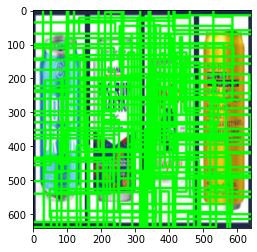

In [52]:
import matplotlib.pyplot as plt
import cv2

image_with_bounding_box = img.numpy()

for i in range(bboxes.shape[0]):
#for i in range(2):
    image_with_bounding_box = cv2.rectangle(image_with_bounding_box, (int(bboxes[i,0]), int(bboxes[i,1])), (int(bboxes[i,2]), int(bboxes[i,3])), (0, 255, 0), 5)
plt.imshow(image_with_bounding_box)

# Testing keras and tensorflow 

In [554]:
class LossLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(LossLayer, self).__init__()
        self.loss_fn = lambda x,y: tf.keras.backend.abs(x - y)

    def call(self, inputs, inputs1):
        if inputs1 is not None:
            self.add_loss(self.loss_fn(inputs,inputs1))
        return inputs

In [556]:
x = np.array([1,2,3,4,5])
y = np.array([5,6,7,8,9]) # learn to add bias
y_fake = np.array([0,0,0,0,0])

In [557]:
input_true = Input(shape=(1))
input_x = Input(shape=(1))
dense = Dense(1)(input_x)
loss = LossLayer()(dense, input_true)

model = Model(inputs=[input_x, input_true], outputs=[loss])
#loss =  tf.abs((dense - input_true))
#model.add_loss(loss)
#model.add_metric(loss, name='kl_loss', aggregation='mean')

In [558]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop()
)

In [559]:
model.summary()

Model: "functional_112"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_146 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 1)            2           input_146[0][0]                  
__________________________________________________________________________________________________
input_145 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
loss_layer_42 (LossLayer)       (None, 1)            0           dense_48[0][0]                   
                                                                 input_145[0][0]     

In [562]:
model.fit([x,y],y_fake, epochs = 2000)

Epoch 1/2000
1/1 [==============================] - 0s 989us/step - loss: 6.4944
Epoch 2/2000
1/1 [==============================] - 0s 2ms/step - loss: 6.4904
Epoch 3/2000
1/1 [==============================] - 0s 3ms/step - loss: 6.4864
Epoch 4/2000
1/1 [==============================] - 0s 2ms/step - loss: 6.4824
Epoch 5/2000
1/1 [==============================] - 0s 2ms/step - loss: 6.4784
Epoch 6/2000
1/1 [==============================] - 0s 3ms/step - loss: 6.4744
Epoch 7/2000
1/1 [==============================] - 0s 1ms/step - loss: 6.4704
Epoch 8/2000
1/1 [==============================] - 0s 3ms/step - loss: 6.4664
Epoch 9/2000
1/1 [==============================] - 0s 1ms/step - loss: 6.4624
Epoch 10/2000
1/1 [==============================] - 0s 3ms/step - loss: 6.4584
Epoch 11/2000
1/1 [==============================] - 0s 2ms/step - loss: 6.4544
Epoch 12/2000
1/1 [==============================] - 0s 3ms/step - loss: 6.4504
Epoch 13/2000
1/1 [============================

1/1 [==============================] - 0s 999us/step - loss: 5.6904
Epoch 203/2000
1/1 [==============================] - 0s 2ms/step - loss: 5.6864
Epoch 204/2000
1/1 [==============================] - 0s 2ms/step - loss: 5.6824
Epoch 205/2000
1/1 [==============================] - 0s 1000us/step - loss: 5.6784
Epoch 206/2000
1/1 [==============================] - 0s 2ms/step - loss: 5.6744
Epoch 207/2000
1/1 [==============================] - 0s 999us/step - loss: 5.6704
Epoch 208/2000
1/1 [==============================] - 0s 999us/step - loss: 5.6664
Epoch 209/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.6624
Epoch 210/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.6584
Epoch 211/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.6544
Epoch 212/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.6504
Epoch 213/2000
1/1 [==============================] - 0s 2ms/step - loss: 5.6464
Epoch 214/2000
1/1 [==============

1/1 [==============================] - 0s 2ms/step - loss: 5.2904
Epoch 303/2000
1/1 [==============================] - 0s 998us/step - loss: 5.2864
Epoch 304/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.2824
Epoch 305/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.2784
Epoch 306/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.2744
Epoch 307/2000
1/1 [==============================] - 0s 993us/step - loss: 5.2704
Epoch 308/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.2664
Epoch 309/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.2624
Epoch 310/2000
1/1 [==============================] - 0s 2ms/step - loss: 5.2584
Epoch 311/2000
1/1 [==============================] - 0s 1ms/step - loss: 5.2544
Epoch 312/2000
1/1 [==============================] - 0s 2ms/step - loss: 5.2504
Epoch 313/2000
1/1 [==============================] - 0s 2ms/step - loss: 5.2464
Epoch 314/2000
1/1 [===================

1/1 [==============================] - 0s 998us/step - loss: 4.4904
Epoch 503/2000
1/1 [==============================] - 0s 999us/step - loss: 4.4864
Epoch 504/2000
1/1 [==============================] - 0s 998us/step - loss: 4.4824
Epoch 505/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.4784
Epoch 506/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.4744
Epoch 507/2000
1/1 [==============================] - 0s 1000us/step - loss: 4.4704
Epoch 508/2000
1/1 [==============================] - 0s 2ms/step - loss: 4.4664
Epoch 509/2000
1/1 [==============================] - 0s 2ms/step - loss: 4.4624
Epoch 510/2000
1/1 [==============================] - 0s 998us/step - loss: 4.4584
Epoch 511/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.4544
Epoch 512/2000
1/1 [==============================] - 0s 998us/step - loss: 4.4504
Epoch 513/2000
1/1 [==============================] - 0s 2ms/step - loss: 4.4464
Epoch 514/2000
1/1 [==========

1/1 [==============================] - 0s 2ms/step - loss: 4.0904
Epoch 603/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.0864
Epoch 604/2000
1/1 [==============================] - 0s 997us/step - loss: 4.0824
Epoch 605/2000
1/1 [==============================] - 0s 1000us/step - loss: 4.0784
Epoch 606/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.0744
Epoch 607/2000
1/1 [==============================] - 0s 999us/step - loss: 4.0704
Epoch 608/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.0664
Epoch 609/2000
1/1 [==============================] - 0s 997us/step - loss: 4.0624
Epoch 610/2000
1/1 [==============================] - 0s 2ms/step - loss: 4.0584
Epoch 611/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.0544
Epoch 612/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.0504
Epoch 613/2000
1/1 [==============================] - 0s 1000us/step - loss: 4.0464
Epoch 614/2000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 3.2904
Epoch 803/2000
1/1 [==============================] - 0s 1ms/step - loss: 3.2864
Epoch 804/2000
1/1 [==============================] - 0s 2ms/step - loss: 3.2824
Epoch 805/2000
1/1 [==============================] - 0s 2ms/step - loss: 3.2784
Epoch 806/2000
1/1 [==============================] - 0s 1ms/step - loss: 3.2744
Epoch 807/2000
1/1 [==============================] - 0s 2ms/step - loss: 3.2704
Epoch 808/2000
1/1 [==============================] - 0s 2ms/step - loss: 3.2664
Epoch 809/2000
1/1 [==============================] - 0s 2ms/step - loss: 3.2624
Epoch 810/2000
1/1 [==============================] - 0s 2ms/step - loss: 3.2584
Epoch 811/2000
1/1 [==============================] - 0s 1ms/step - loss: 3.2544
Epoch 812/2000
1/1 [==============================] - 0s 2ms/step - loss: 3.2504
Epoch 813/2000
1/1 [==============================] - 0s 1ms/step - loss: 3.2464
Epoch 814/2000
1/1 [=======================

1/1 [==============================] - 0s 999us/step - loss: 2.4944
Epoch 1002/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.4904
Epoch 1003/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.4864
Epoch 1004/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.4824
Epoch 1005/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.4784
Epoch 1006/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.4744
Epoch 1007/2000
1/1 [==============================] - 0s 997us/step - loss: 2.4704
Epoch 1008/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.4664
Epoch 1009/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.4624
Epoch 1010/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.4584
Epoch 1011/2000
1/1 [==============================] - 0s 999us/step - loss: 2.4544
Epoch 1012/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.4504
Epoch 1013/2000
1/1 [=====

1/1 [==============================] - 0s 2ms/step - loss: 2.0984
Epoch 1101/2000
1/1 [==============================] - 0s 998us/step - loss: 2.0944
Epoch 1102/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.0904
Epoch 1103/2000
1/1 [==============================] - 0s 997us/step - loss: 2.0864
Epoch 1104/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.0824
Epoch 1105/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.0784
Epoch 1106/2000
1/1 [==============================] - 0s 998us/step - loss: 2.0744
Epoch 1107/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.0704
Epoch 1108/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.0664
Epoch 1109/2000
1/1 [==============================] - 0s 997us/step - loss: 2.0624
Epoch 1110/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.0584
Epoch 1111/2000
1/1 [==============================] - 0s 2ms/step - loss: 2.0544
Epoch 1112/2000
1/1 [===

1/1 [==============================] - 0s 1ms/step - loss: 1.7024
Epoch 1200/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.6984
Epoch 1201/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.6944
Epoch 1202/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.6904
Epoch 1203/2000
1/1 [==============================] - 0s 998us/step - loss: 1.6864
Epoch 1204/2000
1/1 [==============================] - 0s 998us/step - loss: 1.6824
Epoch 1205/2000
1/1 [==============================] - 0s 999us/step - loss: 1.6784
Epoch 1206/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.6744
Epoch 1207/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.6704
Epoch 1208/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.6664
Epoch 1209/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.6624
Epoch 1210/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.6584
Epoch 1211/2000
1/1 [=====

1/1 [==============================] - 0s 1ms/step - loss: 1.3063
Epoch 1299/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.3023
Epoch 1300/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.2983
Epoch 1301/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2943
Epoch 1302/2000
1/1 [==============================] - 0s 1000us/step - loss: 1.2903
Epoch 1303/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2863
Epoch 1304/2000
1/1 [==============================] - 0s 998us/step - loss: 1.2823
Epoch 1305/2000
1/1 [==============================] - 0s 2ms/step - loss: 1.2783
Epoch 1306/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.2743
Epoch 1307/2000
1/1 [==============================] - 0s 999us/step - loss: 1.2703
Epoch 1308/2000
1/1 [==============================] - 0s 999us/step - loss: 1.2663
Epoch 1309/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.2623
Epoch 1310/2000
1/1 [==

1/1 [==============================] - 0s 2ms/step - loss: 0.8069
Epoch 1495/2000
1/1 [==============================] - 0s 999us/step - loss: 0.8067
Epoch 1496/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8063
Epoch 1497/2000
1/1 [==============================] - 0s 999us/step - loss: 0.8060
Epoch 1498/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8062
Epoch 1499/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8057
Epoch 1500/2000
1/1 [==============================] - 0s 999us/step - loss: 0.8052
Epoch 1501/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8056
Epoch 1502/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8052
Epoch 1503/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.8046
Epoch 1504/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.8046
Epoch 1505/2000
1/1 [==============================] - 0s 999us/step - loss: 0.8046
Epoch 1506/2000
1/1 [===

Epoch 1692/2000
1/1 [==============================] - 0s 999us/step - loss: 0.7492
Epoch 1693/2000
1/1 [==============================] - 0s 999us/step - loss: 0.7486
Epoch 1694/2000
1/1 [==============================] - 0s 999us/step - loss: 0.7482
Epoch 1695/2000
1/1 [==============================] - 0s 1000us/step - loss: 0.7484
Epoch 1696/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7478
Epoch 1697/2000
1/1 [==============================] - 0s 1000us/step - loss: 0.7472
Epoch 1698/2000
1/1 [==============================] - 0s 999us/step - loss: 0.7474
Epoch 1699/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.7471
Epoch 1700/2000
1/1 [==============================] - 0s 999us/step - loss: 0.7465
Epoch 1701/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7460
Epoch 1702/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7463
Epoch 1703/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7458


Epoch 1889/2000
1/1 [==============================] - 0s 999us/step - loss: 0.6905
Epoch 1890/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6899
Epoch 1891/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6893
Epoch 1892/2000
1/1 [==============================] - 0s 999us/step - loss: 0.6893
Epoch 1893/2000
1/1 [==============================] - 0s 2ms/step - loss: 0.6891
Epoch 1894/2000
1/1 [==============================] - 0s 999us/step - loss: 0.6885
Epoch 1895/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6880
Epoch 1896/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6884
Epoch 1897/2000
1/1 [==============================] - 0s 999us/step - loss: 0.6878
Epoch 1898/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6872
Epoch 1899/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6871
Epoch 1900/2000
1/1 [==============================] - 0s 1000us/step - loss: 0.6871
Epoch

In [563]:
model.predict([x, y_fake])

array([[3.5936537],
       [5.062336 ],
       [6.5310183],
       [7.9997005],
       [9.468383 ]], dtype=float32)

In [515]:
model.trainable_weights

[<tf.Variable 'dense_47/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.7529033]], dtype=float32)>,
 <tf.Variable 'dense_47/bias:0' shape=(1,) dtype=float32, numpy=array([0.20914188], dtype=float32)>]

In [289]:
loss = LossLayer()
loss(x,y)

<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 2, 3, 4, 5])>

In [342]:
model.losses

[<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.651556 ],
        [ 7.3031116],
        [ 8.954667 ],
        [10.606223 ],
        [12.257779 ]], dtype=float32)>]

In [391]:
epochs = 100
optimizer = tf.keras.optimizers.Adam()
true_box =  tf.expand_dims(bbox_data[5], 0)
ost = tf.expand_dims(output_scores_test[5], 0)
odt = tf.expand_dims(output_deltas_test[5], 0)
my_loss_fn(true_box, ost, odt, tf.cast(generate_bbox_coords(), dtype = tf.float32))

for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))


        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            result = model([x, y], training = True)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
            loss_value = my_loss_fn(true_box, ost, odt, tf.cast(generate_bbox_coords(), dtype = tf.float32))
            print(loss_value)
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)
            #print(model.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))



Start of epoch 0


AttributeError: 'list' object has no attribute 'dtype'

In [343]:
model.trainable_weights

[<tf.Variable 'dense_21/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.6515558]], dtype=float32)>,
 <tf.Variable 'dense_21/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [345]:
model.trainable_weights

[<tf.Variable 'dense_21/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.64155585]], dtype=float32)>,
 <tf.Variable 'dense_21/bias:0' shape=(1,) dtype=float32, numpy=array([0.01000006], dtype=float32)>]

In [355]:
tf.math.reduce_sum(model.losses)

<tf.Tensor: shape=(), dtype=float32, numpy=16724.955>

In [359]:
grads

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[15.]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([5.], dtype=float32)>]

In [395]:

input_x = Input(shape=(1))
dense = Dense(1)(input_x)

model = Model(inputs=[input_x], outputs=[dense])

In [ ]:
model.add_loss()

In [371]:
xtest = np.array([1])
ytest = np.array([5])

In [373]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x, y, batch_size=5, epochs=400)

test_scores = model.evaluate(xtest, ytest, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/400
1/1 [==============================] - 0s 999us/step - loss: 8.3848 - accuracy: 0.0000e+00
Epoch 2/400
1/1 [==============================] - 0s 2ms/step - loss: 8.3094 - accuracy: 0.0000e+00
Epoch 3/400
1/1 [==============================] - 0s 1ms/step - loss: 8.2550 - accuracy: 0.0000e+00
Epoch 4/400
1/1 [==============================] - 0s 3ms/step - loss: 8.2096 - accuracy: 0.0000e+00
Epoch 5/400
1/1 [==============================] - 0s 2ms/step - loss: 8.1695 - accuracy: 0.0000e+00
Epoch 6/400
1/1 [==============================] - 0s 3ms/step - loss: 8.1329 - accuracy: 0.0000e+00
Epoch 7/400
1/1 [==============================] - 0s 2ms/step - loss: 8.0988 - accuracy: 0.0000e+00
Epoch 8/400
1/1 [==============================] - 0s 2ms/step - loss: 8.0665 - accuracy: 0.0000e+00
Epoch 9/400
1/1 [==============================] - 0s 3ms/step - loss: 8.0357 - accuracy: 0.0000e+00
Epoch 10/400
1/1 [==============================] - 0s 2ms/step - loss: 8.0061 - accuracy

Epoch 81/400
1/1 [==============================] - 0s 2ms/step - loss: 6.4174 - accuracy: 0.0000e+00
Epoch 82/400
1/1 [==============================] - 0s 2ms/step - loss: 6.3970 - accuracy: 0.0000e+00
Epoch 83/400
1/1 [==============================] - 0s 2ms/step - loss: 6.3766 - accuracy: 0.0000e+00
Epoch 84/400
1/1 [==============================] - 0s 1ms/step - loss: 6.3562 - accuracy: 0.0000e+00
Epoch 85/400
1/1 [==============================] - 0s 998us/step - loss: 6.3359 - accuracy: 0.0000e+00
Epoch 86/400
1/1 [==============================] - 0s 1ms/step - loss: 6.3157 - accuracy: 0.0000e+00
Epoch 87/400
1/1 [==============================] - 0s 999us/step - loss: 6.2954 - accuracy: 0.0000e+00
Epoch 88/400
1/1 [==============================] - 0s 2ms/step - loss: 6.2752 - accuracy: 0.0000e+00
Epoch 89/400
1/1 [==============================] - 0s 1ms/step - loss: 6.2551 - accuracy: 0.0000e+00
Epoch 90/400
1/1 [==============================] - 0s 1000us/step - loss: 6.2

1/1 [==============================] - 0s 1ms/step - loss: 3.6311 - accuracy: 0.0000e+00
Epoch 240/400
1/1 [==============================] - 0s 1ms/step - loss: 3.6162 - accuracy: 0.0000e+00
Epoch 241/400
1/1 [==============================] - 0s 2ms/step - loss: 3.6014 - accuracy: 0.0000e+00
Epoch 242/400
1/1 [==============================] - 0s 999us/step - loss: 3.5867 - accuracy: 0.0000e+00
Epoch 243/400
1/1 [==============================] - 0s 999us/step - loss: 3.5720 - accuracy: 0.0000e+00
Epoch 244/400
1/1 [==============================] - 0s 1ms/step - loss: 3.5573 - accuracy: 0.0000e+00
Epoch 245/400
1/1 [==============================] - 0s 1ms/step - loss: 3.5426 - accuracy: 0.0000e+00
Epoch 246/400
1/1 [==============================] - 0s 999us/step - loss: 3.5280 - accuracy: 0.0000e+00
Epoch 247/400
1/1 [==============================] - 0s 998us/step - loss: 3.5134 - accuracy: 0.0000e+00
Epoch 248/400
1/1 [==============================] - 0s 2ms/step - loss: 3.4989

1/1 [==============================] - 0s 2ms/step - loss: 2.5681 - accuracy: 0.0000e+00
Epoch 319/400
1/1 [==============================] - 0s 2ms/step - loss: 2.5560 - accuracy: 0.0000e+00
Epoch 320/400
1/1 [==============================] - 0s 998us/step - loss: 2.5440 - accuracy: 0.0000e+00
Epoch 321/400
1/1 [==============================] - 0s 1ms/step - loss: 2.5320 - accuracy: 0.0000e+00
Epoch 322/400
1/1 [==============================] - 0s 2ms/step - loss: 2.5201 - accuracy: 0.0000e+00
Epoch 323/400
1/1 [==============================] - 0s 1000us/step - loss: 2.5082 - accuracy: 0.0000e+00
Epoch 324/400
1/1 [==============================] - 0s 2ms/step - loss: 2.4963 - accuracy: 0.0000e+00
Epoch 325/400
1/1 [==============================] - 0s 1000us/step - loss: 2.4844 - accuracy: 0.0000e+00
Epoch 326/400
1/1 [==============================] - 0s 999us/step - loss: 2.4726 - accuracy: 0.0000e+00
Epoch 327/400
1/1 [==============================] - 0s 2ms/step - loss: 2.46

In [381]:
model.predict([[4], [4]])

AssertionError: in user code:

    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\Users\marty\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("loss_layer_24/loss_layer_24/Identity:0", shape=(None, 1), dtype=float32)


In [383]:
loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

In [386]:
loss([5],[1])

<tf.Tensor: shape=(), dtype=int32, numpy=16>

In [393]:
tf.keras.backend.mean(model.losses)

AttributeError: 'list' object has no attribute 'dtype'

In [394]:
model.losses

[<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.8372464],
        [ 7.674493 ],
        [ 9.511739 ],
        [11.348986 ],
        [13.186232 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.835246 ],
        [ 7.6714926],
        [ 9.507739 ],
        [11.343985 ],
        [13.180231 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.833246 ],
        [ 7.6684923],
        [ 9.503738 ],
        [11.338985 ],
        [13.174232 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.8312464],
        [ 7.6654925],
        [ 9.499739 ],
        [11.333985 ],
        [13.168231 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.829246 ],
        [ 7.6624928],
        [ 9.495739 ],
        [11.328985 ],
        [13.162231 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 5.827246 ],
        [ 7.6594925],
        [ 9.491739 ],


In [255]:
input1 = tf.Variable([1,2,3,4,5], dtype = tf.float32)
input2 = tf.Variable([1,2,3,4,5], dtype = tf.float32)

@tf.function
def test_grad(input1, input2):
    return tf.reduce_mean((input1 + input2) * tf.cast(tf.random.categorical(tf.math.log([[0.5, 0.5]]), 5), dtype = tf.float32) )




In [256]:
from datetime import datetime
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

In [257]:
#with tf.GradientTape() as tape:
tf.summary.trace_on(graph=True, profiler=False)
loss = test_grad(input1, input2) * 5 + 1 * 6

with writer.as_default():
              tf.summary.trace_export(
              name="new_func3",
              step=0,
              profiler_outdir=logdir)            
#gradients = tape.gradient([loss], [input1, input2])

#optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [258]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=16.0>

In [259]:
%reload_ext tensorboard
%tensorboard --logdir logs/func

Reusing TensorBoard on port 6006 (pid 3516), started 2:02:32 ago. (Use '!kill 3516' to kill it.)

In [271]:
input1 = tf.Variable([[1,2,3,4,5]], dtype = tf.float32)
input2 = tf.Variable([1,2,3,4,5], dtype = tf.float32)

@tf.function
def test_grad(input1):
    val = tf.shape(input1) > 1
    tf.print(val)
    return val


test_grad(input1)

[0 1]


<tf.Tensor: shape=(2,), dtype=bool, numpy=array([False,  True])>

In [396]:
input1 = tf.transpose(tf.Variable([[1,2,3,4,5]], dtype = tf.int64))
def sampler(A, sample_size = 255):
    tf.print(tf.shape(A))
    if tf.shape(A)[0]<sample_size:
        sample_size = tf.shape(A)[0]
    sample = tf.random.uniform_candidate_sampler(
    A, 1, sample_size, unique = True, range_max = tf.shape(A)[0].numpy(), seed=None, name=None)[0]
    tf.print(sample)
    return(sample)

In [398]:
tf.py_function(func = sampler , inp = [input1, 2], Tout = [tf.int64], name=sampler)

[5 1]
[2 0]


[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 0], dtype=int64)>]

In [33]:
from utils import generate_bbox_coords
generate_bbox_coords()

array([[0.025, 0.025, 0.02 , 0.005],
       [0.025, 0.025, 0.1  , 0.025],
       [0.025, 0.025, 0.2  , 0.05 ],
       ...,
       [0.975, 0.975, 0.005, 0.02 ],
       [0.975, 0.975, 0.025, 0.1  ],
       [0.975, 0.975, 0.05 , 0.2  ]])